CODE BLOCK: 1

In [ ]:
import torch

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 116052877.46it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41035126.63it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33957191.45it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20980758.56it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

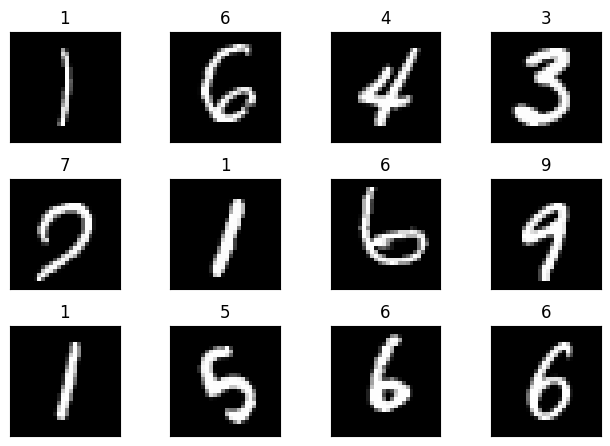

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
#criterion = nn.CrossEntropyLoss()
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2480 Batch_id=19 Accuracy=16.29: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Test set: Average loss: 2.2432, Accuracy: 17650/60000 (29.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=1.9951 Batch_id=19 Accuracy=53.56: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Test set: Average loss: 4.8227, Accuracy: 25154/60000 (41.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.4354 Batch_id=19 Accuracy=60.68: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Test set: Average loss: 0.7585, Accuracy: 45198/60000 (75.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.3436 Batch_id=19 Accuracy=87.37: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Test set: Average loss: 0.4416, Accuracy: 51705/60000 (86.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1486 Batch_id=19 Accuracy=92.73: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


Test set: Average loss: 0.3461, Accuracy: 53741/60000 (89.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1717 Batch_id=19 Accuracy=94.94: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Test set: Average loss: 0.2780, Accuracy: 54993/60000 (91.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0747 Batch_id=19 Accuracy=96.06: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Test set: Average loss: 0.2418, Accuracy: 55635/60000 (92.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1035 Batch_id=19 Accuracy=96.75: 100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Test set: Average loss: 0.2333, Accuracy: 55882/60000 (93.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0834 Batch_id=19 Accuracy=97.26: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Test set: Average loss: 0.2076, Accuracy: 56349/60000 (93.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0385 Batch_id=19 Accuracy=97.62: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Test set: Average loss: 0.2149, Accuracy: 56244/60000 (93.74%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0938 Batch_id=19 Accuracy=98.03: 100%|██████████| 20/20 [00:02<00:00,  6.68it/s]


Test set: Average loss: 0.1927, Accuracy: 56659/60000 (94.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0567 Batch_id=19 Accuracy=98.31: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Test set: Average loss: 0.1995, Accuracy: 56566/60000 (94.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0525 Batch_id=19 Accuracy=98.27: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Test set: Average loss: 0.2010, Accuracy: 56620/60000 (94.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0356 Batch_id=19 Accuracy=98.58: 100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


Test set: Average loss: 0.2030, Accuracy: 56641/60000 (94.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0262 Batch_id=19 Accuracy=98.77: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Test set: Average loss: 0.2073, Accuracy: 56660/60000 (94.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0319 Batch_id=19 Accuracy=99.07: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Test set: Average loss: 0.1892, Accuracy: 56890/60000 (94.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0297 Batch_id=19 Accuracy=99.34: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Test set: Average loss: 0.1897, Accuracy: 56898/60000 (94.83%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0331 Batch_id=19 Accuracy=99.33: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Test set: Average loss: 0.1940, Accuracy: 56899/60000 (94.83%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0280 Batch_id=19 Accuracy=99.36: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Test set: Average loss: 0.1867, Accuracy: 56940/60000 (94.90%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0319 Batch_id=19 Accuracy=99.39: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Test set: Average loss: 0.1863, Accuracy: 56959/60000 (94.93%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

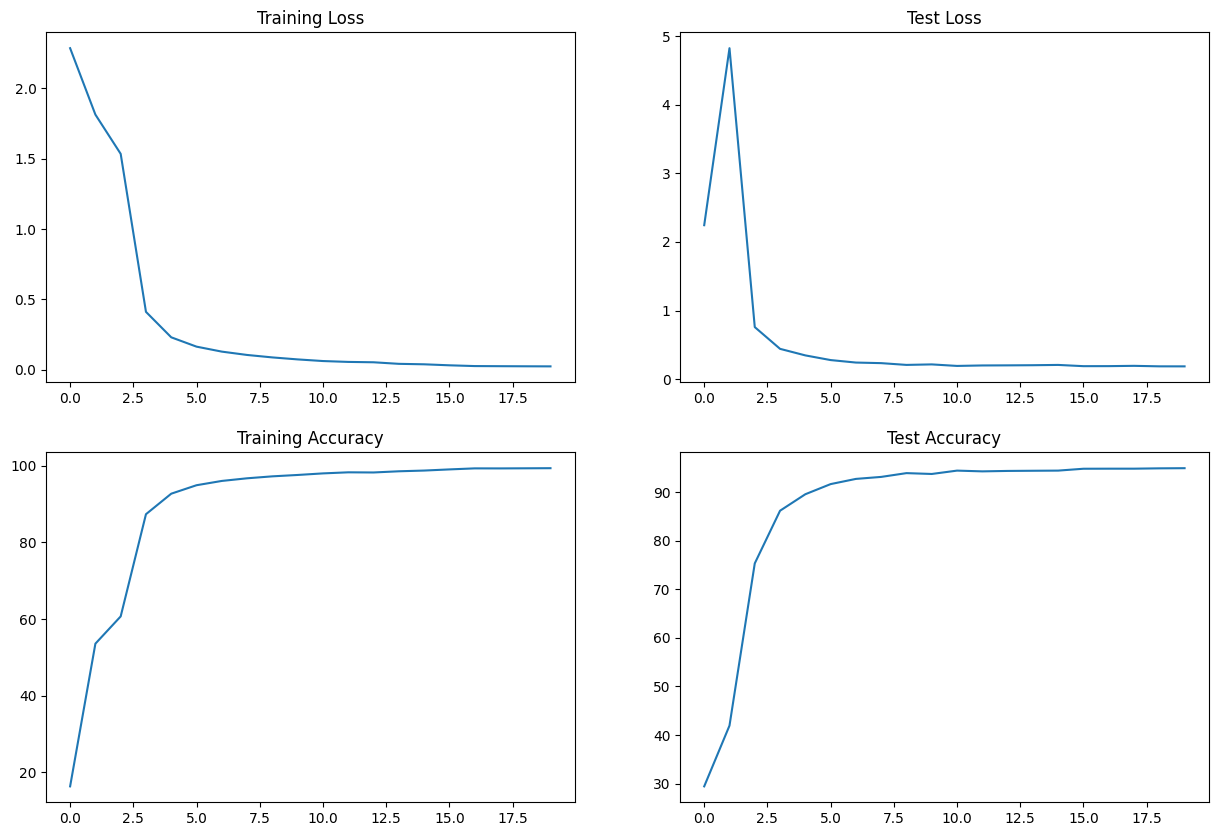

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
